In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline


/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_image_grid(images, n_images=20, per_row=5, img_size=(1, 28, 28)):
    reshaped_images = (images[:n_images].cpu().view(n_images, *img_size) + 1.0) / 2
    plt.imshow(make_grid(reshaped_images, nrow=per_row).permute(1, 2, 0), cmap='gray')
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

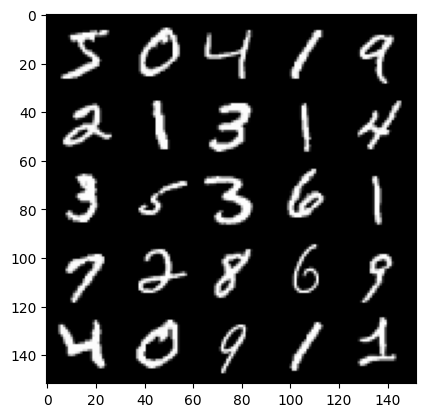

In [3]:
import pathlib
mnist_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/mnist"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_dataset = MNIST(mnist_root, train=True, transform=transform, download=True)

show_image_grid(torch.concat([extracted[0] for extracted in [mnist_dataset[i] for i in range(25)]]), 25)

In [4]:
class DcGenerator(nn.Module):

    #  1) Do a transposed convolution using the given parameters.
    #  2) Do a batchnorm, except for the last layer.
    #  3) Follow each batchnorm with a ReLU activation.
    #  4) If its the final layer, use a Tanh activation after the deconvolution.
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

    def __init__(self, latent_dim, hidden_dim, image_channels) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.cnn = nn.Sequential(
            self.make_gen_block(latent_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, image_channels, kernel_size=4, final_layer=True),
        )
    
    def make_noise_shaped(self, noise):
        return noise.view(-1, self.latent_dim, 1, 1)
    
    def forward(self, noise):
        noise = self.make_noise_shaped(noise)
        return self.cnn(noise)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)


In [5]:
class DcCritic(nn.Module):

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        #  1) Add a convolutional layer using the given parameters.
        #  2) Do a batchnorm, except for the last layer.
        #  3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        if final_layer:
            return nn.Conv2d(input_channels, output_channels, kernel_size, stride)
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        
    def __init__(self, image_channels, hidden_dim) -> None:
        super().__init__()

        self.cnn = nn.Sequential(
            self.make_disc_block(image_channels, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )

    def forward(self, x):
        x = self.cnn(x)
        return x.view(x.size(0), -1) # flatter (batch_size, 1)

In [7]:
n_epochs = 100
z_dim = 64
gen_hidden_dim = 64
crit_hidden_dim = 16
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cpu'

In [9]:
gen = DcGenerator(z_dim, hidden_dim=gen_hidden_dim, image_channels=1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = DcCritic(image_channels=1, hidden_dim=crit_hidden_dim).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [10]:

def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [11]:
# UNIT TEST
# DO NOT MODIFY THIS
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


In [20]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_penalty
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.nn.functional.mse_loss(gradient_norm, torch.ones_like(gradient_norm))
    #### END CODE HERE ####
    return penalty

In [21]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")

Success!


In [22]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss =  -1. * torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [23]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)),
    torch.tensor(-1.0)
)
print("Success!")

Success!


In [24]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [25]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


In [26]:
dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True)

 11%|█         | 50/469 [00:33<04:39,  1.50it/s]

Step 50: Generator loss: 19.889273719787596, critic loss: -3.2610138323307045


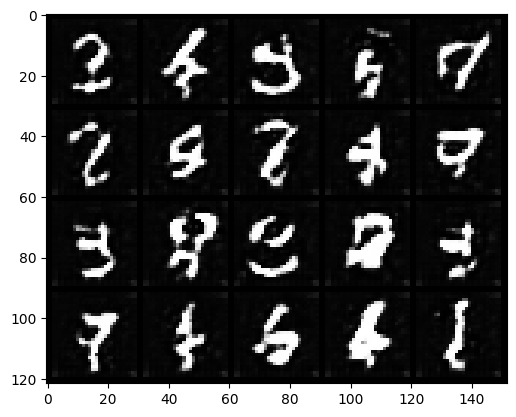

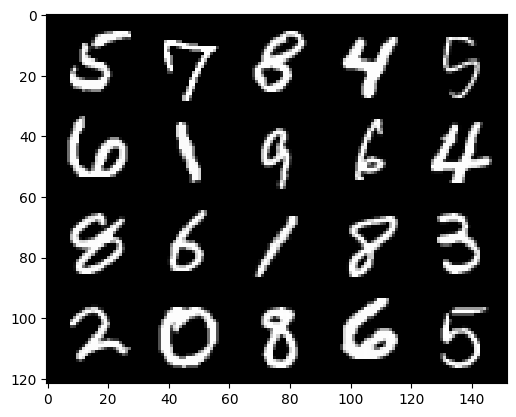

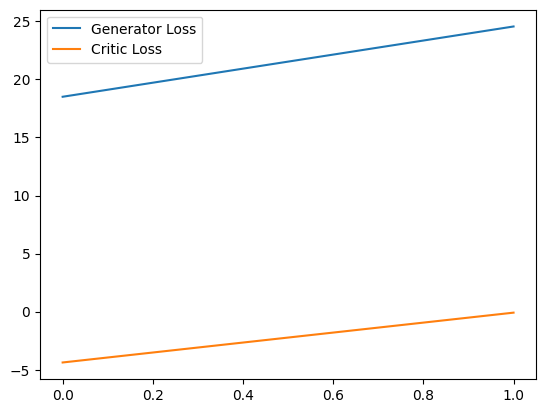

 11%|█         | 50/469 [00:34<04:46,  1.46it/s]


In [30]:
# import matplotlib.pyplot as plt
n_epochs = 1
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_image_grid(fake)
            show_image_grid(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
            break

        cur_step += 1
